In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random

In [12]:
words = open('../data/names.txt', 'r').read().splitlines()

In [13]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi['.'] = 0
itoch = {i:ch for ch, i in chtoi.items()}
vocab_size = len(itoch)
print(itoch)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [14]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = chtoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xval, Yval = build_dataset(words[n1:n2])   # 10%
Xtest,  Ytest  = build_dataset(words[n2:])     # 10%

torch.Size([182674, 3]) torch.Size([182674])
torch.Size([22671, 3]) torch.Size([22671])
torch.Size([22801, 3]) torch.Size([22801])


In [15]:
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden))
    B1 = torch.randn(n_hidden)
    W2 = torch.randn((n_hidden, vocab_size)) 
    B2 = torch.randn(vocab_size)

    params = [C, W1, B1, W2, B2]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2


In [45]:
def train(n_iters, lr, lossi, batch_size=32):
    for i in range(n_iters):
        
        # creating mini batch
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass
        emb = C[Xb] # embed characters to vectors
        embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
        hpreact = embcat @ W1 + B1 # hidden layer pre-activation 
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Yb)

        params = [C, W1, B1, W2, B2]

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()

        #update params
        for p in params:
            p.data += -lr * p.grad 

        # track stats
        if i % 10_000 == 0: # print loss every 10k steps
            print(f'step {i:7d} of {n_iters:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item()) # keeping track of log10 of losses

    return lossi    

In [31]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [32]:
def sample(n_samples=20):
    for _ in range(20):
        out = []
        context = [0] * block_size # init context with all dots ...
        while True:
            emb = C[torch.tensor([context])] # (1, block_size, d)
            h = torch.tanh(emb.view(1, -1) @ W1 + B1)
            logits = h @ W2 + B2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print(''.join(itoch[i] for i in out))    

In [46]:
C, W1, B1, W2, B2 = init_params()

11897


In [47]:
lossi = []
lossi = train(n_iters=50_000, lossi=lossi, lr=0.1)

step       0 of   50000: 26.0871
step   10000 of   50000: 2.7375
step   20000 of   50000: 2.3294
step   30000 of   50000: 2.3164
step   40000 of   50000: 2.4084


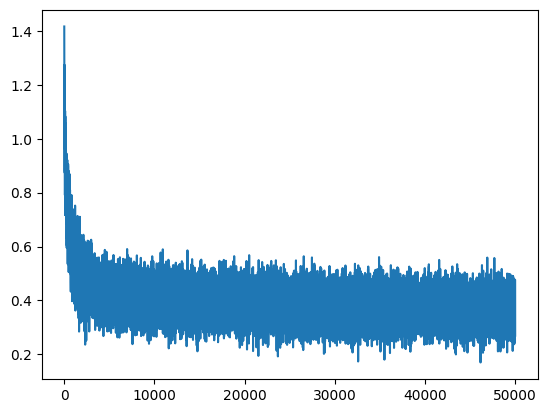

In [48]:
plt.plot(lossi)